**Name: Nidhi Rajkumar Saini**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn.cluster import SpectralClustering
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [2]:
tableHeaders = ["data", "error", "accuracy", "precision", "recall", "f1-score", "AUC"]
metrics_summaries = {}

In [3]:
# Normaliziation using MinMaxScaler
def normalize(df):
    scaler = MinMaxScaler()
    df_new = scaler.fit_transform(df)
    df_new = pd.DataFrame(data = df_new, columns = df.columns)
    return df_new

In [4]:
def SVC_CV(model, trainX, trainY, cv_type):
    # Train classifier with 5 fold cross validation
    C_range = np.logspace(-2, 7, 20) # -4,10,15
    param_grid = dict(C = C_range)
    if(cv_type == 'StratifiedKFold'):
        cv = StratifiedKFold(n_splits = 5)
    else:
        cv = StratifiedShuffleSplit(n_splits = 5)
    grid = GridSearchCV(model, param_grid = param_grid, cv = cv)
    grid.fit(trainX, trainY)
    
    return grid.best_params_, grid.best_score_

In [5]:
def runSVC(X_train, Y_train, cv_type):
    # initializing classifier with default C parameter
    clf = LinearSVC(penalty = 'l1', dual = False, max_iter = 10000)
    
    # get best parameter setting by SVC with CV
    best_params, best_score = SVC_CV(clf, X_train, Y_train, cv_type)
    # training classifier with best C
    clfnew = LinearSVC(penalty = 'l1', dual = False, C = best_params['C'], max_iter = 10000)
    
    clfnew.fit(X_train, Y_train)
    
    return clfnew, best_params, best_score

In [6]:
# Split dataframe based on 'Diagnosis' to get 'testsize'% of both positive and negative classes in test set randomly
def split_data(df, testsize):
    df_B = df[df['Diagnosis'] == 1]
    df_M = df[df['Diagnosis'] == 0]
    train_df_B, test_df_B = train_test_split(df_B, test_size = testsize)
    train_df_M, test_df_M = train_test_split(df_M, test_size = testsize)
    
    train_df = pd.concat([train_df_B, train_df_M], axis = 0)
    train_df = train_df.sample(frac = 1).reset_index(drop = True)
#     print("Train DF:\n",train_df)

    test_df = pd.concat([test_df_B, test_df_M], axis = 0)
    test_df = test_df.sample(frac = 1).reset_index(drop = True)
#     print("Test DF:\n",test_df)

    Xtrain = train_df.iloc[:, 2:]
    Ytrain = train_df.iloc[:, 1]
    Xtest = test_df.iloc[:, 2:]
    Ytest = test_df.iloc[:, 1]
    
    return train_df, test_df, Xtrain, Ytrain, Xtest, Ytest

In [7]:
# get error, accuracy, precision, recall, F1-score, and AUC
def get_metrics(model, X, Y, Y_pred):
    clf_report = classification_report(Y, Y_pred, output_dict = True)
    
    if("kmeans" or "SpectralClustering" in str(type(model))):
        accuracy = clf_report['accuracy']
    else:
        accuracy = model.score(X, Y)
    precision = clf_report['macro avg']['precision']
    recall = clf_report['macro avg']['recall']
    f1score = f1_score(Y, Y_pred, average = 'macro')
    fpr, tpr, thresholds = roc_curve(Y, Y_pred)
    roc_auc = round(auc(fpr, tpr), 4)
    error = 1-accuracy
    
    return [error, accuracy, precision, recall, f1score, roc_auc]

In [8]:
def plot_roc(Y_true, Y_pred, title):
    print("{} metrics:".format(title))
    
    conf_mat = confusion_matrix(Y_true, Y_pred)
    print("Confusion matrix:\n{}".format(conf_mat))
    
    clf_report = classification_report(Y_true, Y_pred, output_dict = True)
    accuracy = clf_report['accuracy']
    print("The classification accuracy is %0.4f." % accuracy)    
    fpr, tpr, thresholds = roc_curve(Y_true, Y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy',  linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc = "lower right")
    plt.title("ROC curve of {} set".format(title))
    plt.show()

In [9]:
def MC_supervised_L1SVC(n, data):
    train_metrics = []
    test_metrics = []
    tableData = []
    print("Supervised Learning - L1-penalized SVC with CV:")
    
    for i in range(n):
        print("\n*************************************Run {}**************************************\n".format(i + 1))
        
        train_df, test_df, X_train, Y_train, X_test, Y_test = split_data(data, 0.2)
        normalized_Xtrain = normalize(X_train)
        normalized_Xtest = normalize(X_test)
        
        # train model with choosing best penalty parameter C using CV
        clf, best_params, best_score = runSVC(normalized_Xtrain, Y_train, 'StratifiedShuffleSplit')
        print("The best parameter setting is %s with a score of %0.4f." % (best_params, best_score))    
        
        # predict and evaluate the model
        # training
        Ytrain_pred = clf.predict(normalized_Xtrain)
        train_metrics.append(get_metrics(clf, normalized_Xtrain, Y_train, Ytrain_pred))     

        # test
        Ytest_pred = clf.predict(normalized_Xtest)
        test_metrics.append(get_metrics(clf, normalized_Xtest, Y_test, Ytest_pred))
        
        print("~ Train error : {:.4f}, Test error : {:.4f}, F1-score : {:.4f}".format(train_metrics[i][0], test_metrics[i][0], test_metrics[i][4]))
    
    print("\n*********************************************************************************\n")
    
    print("\nReport of {}th run:\n".format(i+1))
    plot_roc(Y_train, Ytrain_pred, 'Train')
    plot_roc(Y_test, Ytest_pred, 'Test')
    
    print("\nAverage Metrics Summary of {} runs:\n".format(i+1))
    avg_train_metrics = np.asarray(train_metrics).mean(axis = 0).tolist()
    avg_test_metrics = np.asarray(test_metrics).mean(axis = 0).tolist()
    avg_train_metrics.insert(0, "Train")
    avg_test_metrics.insert(0, "Test")
    tableData.append(avg_train_metrics)
    tableData.append(avg_test_metrics)
    print(tabulate(tableData, tableHeaders, tablefmt="grid"))
    
    return tableData

In [10]:
def MC_semi_supervised_L1SVC(n, data):
    train_metrics = []
    test_metrics = []
    tableData = []
    print("Semi-supervised Learning - L1-penalized SVC with CV:")
    
    for i in range(n):
        print("\n*************************************Run {}**************************************\n".format(i + 1))
        
        train_df, test_df, X_train, Y_train, X_test, Y_test = split_data(data, 0.2)
        train_df.iloc[:,2:] = normalize(train_df.iloc[:,2:])
        normalized_X_test = normalize(X_test)
        labelled_traindf, unlabelled_traindf, labelled_Xtrain, labelled_Ytrain, unlabelled_Xtrain, unlabelled_Ytrain = split_data(train_df, 0.5)
        
        # train model with choosing best penalty parameter C using CV
        clf, best_params, best_score = runSVC(labelled_Xtrain, labelled_Ytrain, 'StratifiedShuffleSplit')
        print("The best parameter setting is %s with a score of %0.4f." % (best_params, best_score))
        
        unlabelled_Xtrain = np.asarray(unlabelled_Xtrain)
        while len(unlabelled_Xtrain) > 0:
            # calculate distance from unlabeled data points to decision boundary
            scores = clf.decision_function(unlabelled_Xtrain)
            # sort by the absolute value of distance
            sorted_idx = sorted([i for i in range(len(unlabelled_Xtrain))], key=lambda x : abs(scores[x]))
            unlabelled_Xtrain = [unlabelled_Xtrain[i] for i in sorted_idx]
            farthest_pt = unlabelled_Xtrain.pop()
            unlabelled_Ypred = clf.predict(farthest_pt.reshape(1, -1))
            # remove the farthest point from unlabeled and add it to labeled
            labelled_Xtrain = pd.concat([labelled_Xtrain, pd.DataFrame(farthest_pt.reshape(1,-1), columns=list(labelled_Xtrain))], ignore_index=True)
            labelled_Ytrain = pd.concat([labelled_Ytrain, pd.Series(unlabelled_Ypred)], ignore_index=True)
            # refit the SVC
            clf.fit(labelled_Xtrain, labelled_Ytrain)
        
        # predict and evaluate the model
        # training
        Ytrain_pred = clf.predict(labelled_Xtrain)
        train_metrics.append(get_metrics(clf, labelled_Xtrain, labelled_Ytrain, Ytrain_pred))     

        # test
        Ytest_pred = clf.predict(normalized_X_test)
        test_metrics.append(get_metrics(clf, normalized_X_test, Y_test, Ytest_pred))
        
        print("~ Train error : {:.4f}, Test error : {:.4f}, F1-score : {:.4f}".format(train_metrics[i][0], test_metrics[i][0], test_metrics[i][4]))
        
    print("\n*********************************************************************************\n")
    
    print("\nReport of {}th run:\n".format(i+1))
    plot_roc(labelled_Ytrain, Ytrain_pred, 'Train')
    plot_roc(Y_test, Ytest_pred, 'Test')
    
    print("\nAverage Metrics Summary of {} runs:\n".format(i+1))
    avg_train_metrics = np.asarray(train_metrics).mean(axis = 0).tolist()
    avg_test_metrics = np.asarray(test_metrics).mean(axis = 0).tolist()
    avg_train_metrics.insert(0, "Train")
    avg_test_metrics.insert(0, "Test")
    tableData.append(avg_train_metrics)
    tableData.append(avg_test_metrics)
    print(tabulate(tableData, tableHeaders, tablefmt="grid"))
    
    return tableData

In [11]:
def get_majority_cluster_labels(X, Y, centers, count):
    Y_true_0 = []
    Y_true_1 = []
    
    closest_cluster_labels, distances = vq(X, centers)

    if(count>0):
        idx0 = [(i, closest_cluster_labels[i], distances[i]) for i in range(len(distances)) if closest_cluster_labels[i] == 0]
        idx1 = [(i, closest_cluster_labels[i], distances[i]) for i in range(len(distances)) if closest_cluster_labels[i] == 1]
        idx0 = sorted(idx0, key = lambda x: x[2])
        idx1 = sorted(idx1, key = lambda x: x[2])
        # collect 30 closest train data points for majority polling
        for j in range(count):
            Y_true_0.append(Y.iloc[idx0[j][0]]) 
            Y_true_1.append(Y.iloc[idx1[j][0]])
    # collect all test data points for 50% threshold majority polling
    else:
        Y_true_0 = [Y.iloc[i] for i in range(len(distances)) if closest_cluster_labels[i] == 0]
        Y_true_1 = [Y.iloc[i] for i in range(len(distances)) if closest_cluster_labels[i] == 1]
    
    # get majority label per cluster
    majority_label_cl0 = np.bincount(np.asarray(Y_true_0)).argmax()
    majority_label_cl1 = np.bincount(np.asarray(Y_true_1)).argmax()

    # collect all data points to use for train set evaluation
    if count>0:
        Y_true_0 = [Y.iloc[i] for i in range(len(distances)) if closest_cluster_labels[i] == 0]
        Y_true_1 = [Y.iloc[i] for i in range(len(distances)) if closest_cluster_labels[i] == 1]    
    
    return majority_label_cl0, majority_label_cl1, Y_true_0, Y_true_1

In [12]:
def MC_unsupervised_KMeans(n, data):
    print("Unsupervised Learning - KMeans Clustering:\nKMeans has the drawback of converging at local minima which can be prevented by using multiple random initializations.")
    train_metrics = []
    test_metrics = []
    tableData = []
    
    for i in range(n):
        print("\n*************************************Run {}**************************************\n".format(i + 1))
        
        train_df, test_df, X_train, Y_train, X_test, Y_test = split_data(data, 0.2)
        X_train = normalize(X_train)
        X_test = normalize(X_test)
        
        # fit KMeans and prevent converging at local minima by multiple random initializations
        kmeans = KMeans(n_clusters = 2, n_init = 15).fit(X_train)
        
        # evaluation - Train
        majority_label_c0, majority_label_c1, Y_true_0, Y_true_1 = get_majority_cluster_labels(X_train, Y_train, kmeans.cluster_centers_, 30)
        # assign majority labels as prediction of kmeans for train data
        Y_pred = np.tile(majority_label_c0,(len(Y_true_0),))
        Y_pred = np.concatenate((Y_pred, np.tile(majority_label_c1,(len(Y_true_1),))), axis = None)
        Y_true = Y_true_0 + Y_true_1        
        train_metrics.append(get_metrics(kmeans, X_train, Y_true, Y_pred))   
        
        # evaluation - Test
        majority_label_c0, majority_label_c1, Y_true_0, Y_true_1 = get_majority_cluster_labels(X_test, Y_test, kmeans.cluster_centers_, -1)
        # assign majority labels as prediction of kmeans for test data
        Y_test_pred = np.tile(majority_label_c0,(len(Y_true_0),))
        Y_test_pred = np.concatenate((Y_test_pred, np.tile(majority_label_c1,(len(Y_true_1),))), axis = None)
        Y_test_true = Y_true_0 + Y_true_1
        test_metrics.append(get_metrics(kmeans, X_test, Y_test_true, Y_test_pred))   
        
        print("~ Train error : {:.4f}, Test error : {:.4f}, F1-score : {:.4f}".format(train_metrics[i][0], test_metrics[i][0], test_metrics[i][4]))
    
    print("\n*********************************************************************************\n")
    
    print("\nReport of {}th run:\n".format(i+1))
    plot_roc(Y_true, Y_pred, 'Train')
    plot_roc(Y_test_true, Y_test_pred, 'Test')
    
    print("\nAverage Metrics Summary of {} runs:\n".format(i+1))
    avg_train_metrics = np.asarray(train_metrics).mean(axis = 0).tolist()
    avg_test_metrics = np.asarray(test_metrics).mean(axis = 0).tolist()
    avg_train_metrics.insert(0, "Train")
    avg_test_metrics.insert(0, "Test")
    tableData.append(avg_train_metrics)
    tableData.append(avg_test_metrics)
    print(tabulate(tableData, tableHeaders, tablefmt="grid"))
    
    return tableData

In [13]:
# get actual and predicted data points for evaulation of Spectral clustering
def get_Ytrue_Ypred(Y, cluster_labels):
    Y_true_0 = []
    Y_true_1 = []
    
    # Because Spectral Clustering will not give us cluster centers, instead of considering 30 closest data points 
    # to the center like KMeans, labeling based on the majority polling of entire points in each cluster.
    Y_true_0 = [Y.iloc[i] for i in range(len(cluster_labels)) if cluster_labels[i] == 0]
    Y_true_1 = [Y.iloc[i] for i in range(len(cluster_labels)) if cluster_labels[i] == 1]
    
    # get majority label per cluster
    majority_label_c0 = np.bincount(np.asarray(Y_true_0)).argmax()
    majority_label_c1 = np.bincount(np.asarray(Y_true_1)).argmax()
    
    # assign majority labels as prediction of Spectral clustering
    Y_pred = np.tile(majority_label_c0,(len(Y_true_0),))
    Y_pred = np.concatenate((Y_pred, np.tile(majority_label_c1,(len(Y_true_1),))), axis = None)
    
    # construct Y_true for actual data points
    Y_true = Y_true_0 + Y_true_1
    
    return Y_true, Y_pred

In [14]:
def MC_spectral_clustering(n, data):
    print("Unsupervised Learning - Spectral Clustering:\n")
    train_metrics = []
    test_metrics = []
    tableData = []
    
    for i in range(n):
        print("\n*************************************Run {}**************************************\n".format(i + 1))
        
        train_df, test_df, X_train, Y_train, X_test, Y_test = split_data(data, 0.2)
        X_train = normalize(X_train)
        X_test = normalize(X_test)
        
        # create spectral clusters
        sc = SpectralClustering(n_clusters = 2, affinity = 'rbf', gamma = 1, n_init = 15)
        
        # evaluation - Train
        train_cluster_labels = sc.fit_predict(X_train)
        Y_train_true, Y_train_pred = get_Ytrue_Ypred(Y_train, train_cluster_labels)       
        train_metrics.append(get_metrics(sc, X_train, Y_train_true, Y_train_pred))  
        
        # evaluation - Test
        test_cluster_labels = sc.fit_predict(X_test)
        Y_test_true, Y_test_pred = get_Ytrue_Ypred(Y_test, test_cluster_labels)        
        test_metrics.append(get_metrics(sc, X_test, Y_test_true, Y_test_pred))  
        
        print("~ Train error : {:.4f}, Test error : {:.4f}, F1-score : {:.4f}".format(train_metrics[i][0], test_metrics[i][0], test_metrics[i][4]))
    
    print("\n*********************************************************************************\n")
    
    print("\nReport of {}th run:\n".format(i+1))
    plot_roc(Y_train_true, Y_train_pred, 'Train')
    plot_roc(Y_test_true, Y_test_pred, 'Test')
    
    print("\nAverage Metrics Summary of {} runs:\n".format(i+1))
    avg_train_metrics = np.asarray(train_metrics).mean(axis = 0).tolist()
    avg_test_metrics = np.asarray(test_metrics).mean(axis = 0).tolist()
    avg_train_metrics.insert(0, "Train")
    avg_test_metrics.insert(0, "Test")
    tableData.append(avg_train_metrics)
    tableData.append(avg_test_metrics)
    print(tabulate(tableData, tableHeaders, tablefmt="grid"))
    
    return tableData

In [15]:
def passive_learning(n, train_df, test_df, learning_curve):
    X_train, Y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    X_test, Y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    X_train = normalize(X_train)
    X_test = normalize(X_test)
    
    train_metrics = []
    test_metrics = []
    tableData = []
    selected_idx = []
    
    all_idx = np.arange(X_train.shape[0])
    # randomize indices of train data
    np.random.shuffle(all_idx)
    
    for i in range(n):

        # select a pool 10 data points without replacement
        pool, all_idx = all_idx[:10], all_idx[10:]
        selected_idx.extend(pool)

        # get new training set and train classifier with CV
        Xtrain_new, Ytrain_new = X_train.iloc[selected_idx,:], Y_train.iloc[selected_idx]
        Xtrain_new.reset_index(drop = True, inplace = True)
        Ytrain_new.reset_index(drop = True, inplace = True)

        # train model with choosing best penalty parameter C using CV
        clf, best_params, best_score = runSVC(Xtrain_new, Ytrain_new, 'StratifiedKFold')
           
        # predict and evaluate the model
        # training
        Ytrain_pred = clf.predict(Xtrain_new)
        train_metrics.append(get_metrics(clf, Xtrain_new, Ytrain_new, Ytrain_pred))     

        # test
        Ytest_pred = clf.predict(X_test)
        test_metrics.append(get_metrics(clf, X_test, Y_test, Ytest_pred))
        
    test_metrics = np.asarray(test_metrics)
    learning_curve += test_metrics[:,0].reshape(n)
    avg_train_metrics = np.asarray(train_metrics).mean(axis = 0).tolist()
    avg_test_metrics = test_metrics.mean(axis = 0).tolist()
    avg_train_metrics.insert(0, "Train")
    avg_test_metrics.insert(0, "Test")
    tableData.append(avg_train_metrics)
    tableData.append(avg_test_metrics)

    return tableData, avg_train_metrics[1:], avg_test_metrics[1:], learning_curve

In [16]:
def MC_passive_learning(MC_n, PL_n, banknote_train_df, banknote_test_df):
    print("Passive Learning: L1-penalized SVC with CV -\n")
    metrics = {}
    train_metrics = np.tile(0.0,(6,))
    test_metrics = np.tile(0.0,(6,))
    learning_curve = np.tile(0.0,(PL_n,))
    
    for each in range(MC_n):
        print("\n--------------------Average metrics after {} iterations of Run {}------------------".format(PL_n, each+1))
        name = 'Run' + str(each + 1)
        metrics[name], avg_train, avg_test, learning_curve = passive_learning(PL_n, banknote_train_df, banknote_test_df, learning_curve)
        train_metrics += avg_train
        test_metrics += avg_test
        print(tabulate(metrics[name], tableHeaders, tablefmt="grid"))
        
    print("\n*************************************************************************************************\n")
    
    return metrics, train_metrics/MC_n, test_metrics/MC_n, learning_curve/MC_n

In [17]:
# get samples of data such that if all selected data points are from one class, select another set of data points randomly.
def get_samples(count, X_train, Y_train):
    classes = set(Y_train.value_counts().keys())
    
    while True:
        selected_idx = np.random.choice(np.arange(len(X_train)), count, replace=False)
        Y_selected = Y_train.iloc[selected_idx]
        sel_classes = set(Y_selected.value_counts().keys())
        
        if classes == sel_classes:
            return X_train.iloc[selected_idx,:], Y_train.iloc[selected_idx], selected_idx

In [18]:
def active_learning(n, train_df, test_df, learning_curve):
    X_train, Y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    X_test, Y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]
    X_train = normalize(X_train)
    X_test = normalize(X_test)
    
    train_metrics = []
    test_metrics = []
    tableData = []
    selected_idx = []
    
    Xtrain_new, Ytrain_new, selected_idx = get_samples(10, X_train, Y_train)
    Xtrain_new.reset_index(drop = True, inplace = True)
    Ytrain_new.reset_index(drop = True, inplace = True)

    for i in range(n):
        # train model with choosing best penalty parameter C using CV
        clf, best_params, best_score = runSVC(Xtrain_new, Ytrain_new, 'StratifiedKFold')
        
        # predict and evaluate the model
        # training
        Ytrain_pred = clf.predict(Xtrain_new)
        train_metrics.append(get_metrics(clf, Xtrain_new, Ytrain_new, Ytrain_pred))     

        # test
        Ytest_pred = clf.predict(X_test)
        test_metrics.append(get_metrics(clf, X_test, Y_test, Ytest_pred))
        
        # find closest data points to the hyperplane of the SVM
        remaining_idx = [idx for idx in np.arange(len(X_train)) if idx not in selected_idx]
        dist = clf.decision_function(X_train.iloc[remaining_idx,:])
        sorted_idx = sorted([i for i in range(len(remaining_idx))], key=lambda x : abs(dist[x]))
        
        # add closest 10 data points to create new training set
        selected_idx = np.concatenate((selected_idx, sorted_idx[:10]), axis=None)
        Xtrain_new = X_train.iloc[selected_idx,:]
        Ytrain_new = Y_train.iloc[selected_idx]
        Xtrain_new.reset_index(drop = True, inplace = True)
        Ytrain_new.reset_index(drop = True, inplace = True)      
        
    test_metrics = np.asarray(test_metrics)
    learning_curve += test_metrics[:, 0].reshape(n,)
    avg_train_metrics = np.asarray(train_metrics).mean(axis = 0).tolist()
    avg_test_metrics = test_metrics.mean(axis = 0).tolist()
    avg_train_metrics.insert(0, "Train")
    avg_test_metrics.insert(0, "Test")
    tableData.append(avg_train_metrics)
    tableData.append(avg_test_metrics)

    return tableData, avg_train_metrics[1:], avg_test_metrics[1:], learning_curve

In [19]:
def MC_active_learning(MC_n, AL_n, banknote_train_df, banknote_test_df):
    print("Active Learning: L1-penalized SVC with CV -\n")
    
    metrics = {}
    train_metrics = np.tile(0.0,(6,))
    test_metrics = np.tile(0.0,(6,))
    learning_curve = np.tile(0.0,(AL_n,))
    
    for each in range(MC_n):
        print("\n--------------------Average metrics after {} iterations of Run {}------------------".format(AL_n, each+1))
        name = 'Run' + str(each + 1)
        metrics[name], avg_train, avg_test, learning_curve = active_learning(AL_n, banknote_train_df, banknote_test_df, learning_curve)
        train_metrics += avg_train
        test_metrics += avg_test
        print(tabulate(metrics[name], tableHeaders, tablefmt="grid"))
        
    print("\n*************************************************************************************************\n")
    
    return metrics, train_metrics/MC_n, test_metrics/MC_n, learning_curve/MC_n

# Supervised, Semi-Supervised, and Unsupervised Learning

## Load the Breast Cancer Wisconsin (Diagnostic) Data Set

In [20]:
wdbc_df = pd.read_csv('../data/wdbc.csv', header = None)
wdbc_df.columns = ['ID', 'Diagnosis'] + ['feature'+str(i) for i in range(1,31)]
wdbc_df

,ID,Diagnosis,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [21]:
wdbc_df['Diagnosis'].value_counts() # (Benign=B, Malignant=M)

B    357
M    212
Name: Diagnosis, dtype: int64

In [22]:
# Label encode 'Diagnosis'
wdbc_df['Diagnosis'], categd = pd.factorize(wdbc_df['Diagnosis'])

In [23]:
categd

Index(['M', 'B'], dtype='object')

In [24]:
wdbc_df['Diagnosis'].value_counts() # 1:Benign 0:Malignant

1    357
0    212
Name: Diagnosis, dtype: int64

In [25]:
wdbc_df

,ID,Diagnosis,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30
0,842302,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Monte-Carlo Simulation

Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positive and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

### Supervised Learning

Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs. 

Supervised Learning - L1-penalized SVC with CV:

*************************************Run 1**************************************

The best parameter setting is {'C': 2.3357214690901213} with a score of 0.9826.
~ Train error : 0.0110, Test error : 0.0087, F1-score : 0.9907

*************************************Run 2**************************************

The best parameter setting is {'C': 0.7847599703514611} with a score of 0.9870.
~ Train error : 0.0220, Test error : 0.0522, F1-score : 0.9457

*************************************Run 3**************************************

The best parameter setting is {'C': 0.08858667904100823} with a score of 0.9652.
~ Train error : 0.0419, Test error : 0.0348, F1-score : 0.9632

*************************************Run 4**************************************

The best parameter setting is {'C': 0.7847599703514611} with a score of 0.9826.
~ Train error : 0.0154, Test error : 0.1217, F1-score : 0.8755

*************************************Run 5****

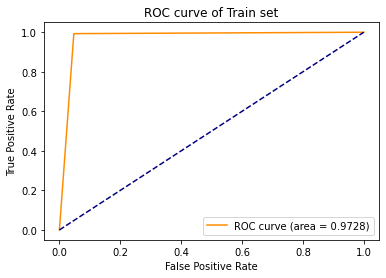

Test metrics:
Confusion matrix:
[[43  0]
 [ 0 72]]
The classification accuracy is 1.0000.


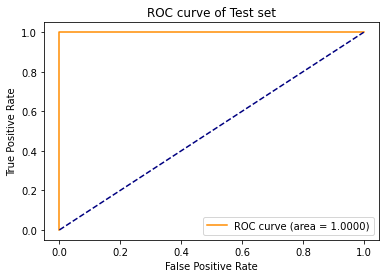


Average Metrics Summary of 30 runs:

+--------+-----------+------------+-------------+----------+------------+----------+
| data   |     error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+===========+============+=============+==========+============+==========+
| Train  | 0.0190162 |   0.980984 |    0.98328  | 0.976184 |   0.979476 | 0.97618  |
+--------+-----------+------------+-------------+----------+------------+----------+
| Test   | 0.0704348 |   0.929565 |    0.930294 | 0.938286 |   0.927363 | 0.938287 |
+--------+-----------+------------+-------------+----------+------------+----------+


In [26]:
metrics_summaries['Supervised Learning: L1-penalized SVC with CV'] = MC_supervised_L1SVC(30, wdbc_df)

### Semi-Supervised Learning/ Self-training

Select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.

#### Train an L1-penalized SVM to classify the labeled data. Use normalized data. Choose the penalty parameter using 5 fold cross validation. <br> Find the unlabeled data point that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data and the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

Semi-supervised Learning - L1-penalized SVC with CV:

*************************************Run 1**************************************

The best parameter setting is {'C': 6.951927961775605} with a score of 0.9739.
~ Train error : 0.0022, Test error : 0.1130, F1-score : 0.8847

*************************************Run 2**************************************

The best parameter setting is {'C': 1623.776739188721} with a score of 0.9826.
~ Train error : 0.0000, Test error : 0.1565, F1-score : 0.8400

*************************************Run 3**************************************

The best parameter setting is {'C': 0.7847599703514611} with a score of 0.9913.
~ Train error : 0.0044, Test error : 0.0435, F1-score : 0.9538

*************************************Run 4**************************************

The best parameter setting is {'C': 2.3357214690901213} with a score of 0.9652.
~ Train error : 0.0044, Test error : 0.0696, F1-score : 0.9275

*************************************Run 5**

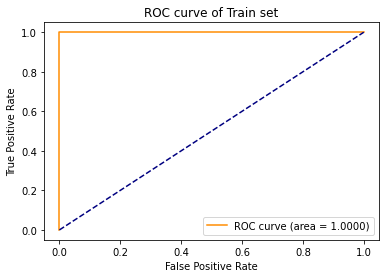

Test metrics:
Confusion matrix:
[[42  1]
 [ 3 69]]
The classification accuracy is 0.9652.


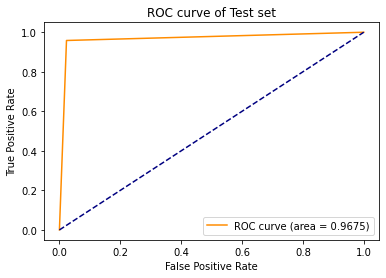


Average Metrics Summary of 30 runs:

+--------+------------+------------+-------------+----------+------------+---------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |     AUC |
+========+============+============+=============+==========+============+=========+
| Train  | 0.00807636 |   0.991924 |    0.993215 | 0.989335 |   0.991182 | 0.98934 |
+--------+------------+------------+-------------+----------+------------+---------+
| Test   | 0.0724638  |   0.927536 |    0.924872 | 0.934168 |   0.924773 | 0.93417 |
+--------+------------+------------+-------------+----------+------------+---------+


In [27]:
metrics_summaries['Semi-supervised Learning: L1-penalized SVC with CV'] = MC_semi_supervised_L1SVC(30, wdbc_df)

### Unsupervised Learning

Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.

#### Run the k-means algorithm multiple times. Make sure that you initialize the algorithm randomly. How do you make sure that the algorithm was not trapped in a local minimum? <br> Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs. <br> Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

Unsupervised Learning - KMeans Clustering:
KMeans has the drawback of converging at local minima which can be prevented by using multiple random initializations.

*************************************Run 1**************************************

~ Train error : 0.0749, Test error : 0.0609, F1-score : 0.9364

*************************************Run 2**************************************

~ Train error : 0.0815, Test error : 0.0522, F1-score : 0.9437

*************************************Run 3**************************************

~ Train error : 0.0793, Test error : 0.0696, F1-score : 0.9242

*************************************Run 4**************************************

~ Train error : 0.0727, Test error : 0.0783, F1-score : 0.9182

*************************************Run 5**************************************

~ Train error : 0.0859, Test error : 0.0783, F1-score : 0.9188

*************************************Run 6**************************************

~ Train error : 0.0727, T

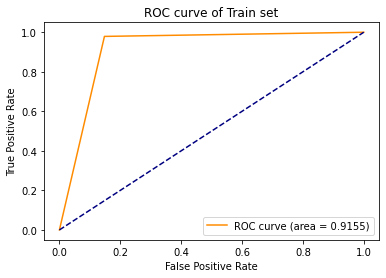

Test metrics:
Confusion matrix:
[[39  4]
 [ 9 63]]
The classification accuracy is 0.8870.


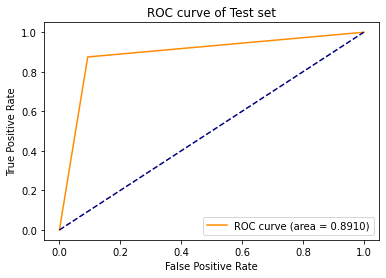


Average Metrics Summary of 30 runs:

+--------+-----------+------------+-------------+----------+------------+----------+
| data   |     error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+===========+============+=============+==========+============+==========+
| Train  | 0.0748164 |   0.925184 |    0.931377 | 0.908739 |   0.917953 | 0.908737 |
+--------+-----------+------------+-------------+----------+------------+----------+
| Test   | 0.0788406 |   0.921159 |    0.917097 | 0.920333 |   0.91662  | 0.920327 |
+--------+-----------+------------+-------------+----------+------------+----------+


In [28]:
metrics_summaries['Unsupervised Learning: KMeans Clustering'] = MC_unsupervised_KMeans(30, wdbc_df)

### Spectral Clustering

Repeat 1.2.3 using spectral clustering , which is clustering based on kernels. Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit−predict method.

=> **‘Spectral Clustering’** uses the connectivity approach to clustering, wherein communities of nodes (i.e. data points) that are connected or immediately next to each other are identified in a graph. The nodes are then mapped to a low-dimensional space that can be easily segregated to form clusters. Spectral Clustering uses information from the eigenvalues (spectrum) of special matrices (i.e. Affinity Matrix, Degree Matrix and Laplacian Matrix) derived from the graph or the data set.<br>
Spectral clustering is flexible and allows us to cluster non-graphical data as well. It makes no assumptions about the form of the clusters. Clustering techniques, like K-Means, assume that the points assigned to a cluster are spherical about the cluster centre. This is a strong assumption and may not always be relevant. In such cases, Spectral Clustering helps create more accurate clusters. It can correctly cluster observations that actually belong to the same cluster, but are farther off than observations in other clusters, due to dimension reduction.<br>
The data points in Spectral Clustering should be connected, but may not necessarily have convex boundaries, as opposed to the conventional clustering techniques, where clustering is based on the compactness of data points. 

Unsupervised Learning - Spectral Clustering:


*************************************Run 1**************************************

~ Train error : 0.1586, Test error : 0.0957, F1-score : 0.8912

*************************************Run 2**************************************

~ Train error : 0.1233, Test error : 0.1478, F1-score : 0.8240

*************************************Run 3**************************************

~ Train error : 0.1476, Test error : 0.0957, F1-score : 0.8926

*************************************Run 4**************************************

~ Train error : 0.1300, Test error : 0.2870, F1-score : 0.5955

*************************************Run 5**************************************

~ Train error : 0.1454, Test error : 0.1739, F1-score : 0.7875

*************************************Run 6**************************************

~ Train error : 0.1784, Test error : 0.1739, F1-score : 0.7912

*************************************Run 7***********************************

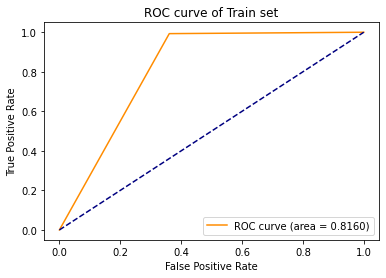

Test metrics:
Confusion matrix:
[[22 21]
 [ 0 72]]
The classification accuracy is 0.8174.


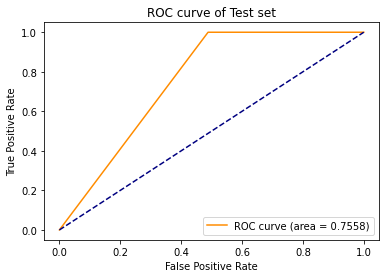


Average Metrics Summary of 30 runs:

+--------+----------+------------+-------------+----------+------------+----------+
| data   |    error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+==========+============+=============+==========+============+==========+
| Train  | 0.143906 |   0.856094 |    0.900439 | 0.808954 |   0.829186 | 0.80895  |
+--------+----------+------------+-------------+----------+------------+----------+
| Test   | 0.167536 |   0.832464 |    0.89368  | 0.777374 |   0.788713 | 0.777377 |
+--------+----------+------------+-------------+----------+------------+----------+


In [29]:
metrics_summaries['Unsupervised Learning: Spectral Clustering'] = MC_spectral_clustering(30, wdbc_df)

### One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled. One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.

In [30]:
print("Average Metrics Summary:\n")
for key in metrics_summaries.keys():
    print(key,":")
    print(tabulate(metrics_summaries[key], tableHeaders, tablefmt="grid"),"\n")

Average Metrics Summary:

Supervised Learning: L1-penalized SVC with CV :
+--------+-----------+------------+-------------+----------+------------+----------+
| data   |     error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+===========+============+=============+==========+============+==========+
| Train  | 0.0190162 |   0.980984 |    0.98328  | 0.976184 |   0.979476 | 0.97618  |
+--------+-----------+------------+-------------+----------+------------+----------+
| Test   | 0.0704348 |   0.929565 |    0.930294 | 0.938286 |   0.927363 | 0.938287 |
+--------+-----------+------------+-------------+----------+------------+----------+ 

Semi-supervised Learning: L1-penalized SVC with CV :
+--------+------------+------------+-------------+----------+------------+---------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |     AUC |
+========+============+============+=============+==========+============+=========+
| Train  | 0.00807636

According to the performance report above, we can observe that the performance comparison of different learning strategies is : supervised > semi-supervised > unsupervised. When comparing these learning methods, we can see that the performance of supervised learning is slightly better than semi-supervised learning on test data, because it involves more actual information on the label variable i.e. complete labeled data set instead of partial. The performance gap between supervised and semi-supervised learning method is significantly smaller than that between supervised and unsupervised cases. The supervised case will have more information of labels to guide their learning while the prediction of unsupervised ones is just based on the similarity of features. Hence, comparing with other two learning methods, unsupervised learning underperforms because it makes prediction just based on the similarity on the predictor variables instead of the label variable.

# Active Learning Using Support Vector Machines

## Load the Banknote authentication data set

In [31]:
banknote_df = pd.read_csv('../data/data_banknote_authentication.txt', header = None)
banknote_df.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
banknote_df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [32]:
banknote_df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

### Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [33]:
banknote_train_df, banknote_test_df = train_test_split(banknote_df, test_size = 472)
banknote_train_df.reset_index(drop = True, inplace = True)
banknote_test_df.reset_index(drop = True, inplace = True)

## Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

### Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.

In [34]:
tableData = []

pl_metrics, pl_train_metrics, pl_test_metrics, pl_curve = MC_passive_learning(50, 90, banknote_train_df, banknote_test_df)

train = list(pl_train_metrics)
train.insert(0,"Train")
test = list(pl_test_metrics)
test.insert(0,"Test")
tableData.append(train)
tableData.append(test)
metrics_summaries['Passive Learning: L1-penalized SVC with CV'] = tableData

print("Final average metrics of Passive Learning Monte-Carlo simulation:\n")
print(tabulate(tableData, tableHeaders, tablefmt="grid"))

Passive Learning: L1-penalized SVC with CV -


--------------------Average metrics after 90 iterations of Run 1------------------
+--------+------------+------------+-------------+----------+------------+---------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |     AUC |
+========+============+============+=============+==========+============+=========+
| Train  | 0.00700898 |   0.992991 |    0.992893 | 0.9931   |   0.992933 | 0.9931  |
+--------+------------+------------+-------------+----------+------------+---------+
| Test   | 0.0268597  |   0.97314  |    0.975975 | 0.970652 |   0.972713 | 0.97066 |
+--------+------------+------------+-------------+----------+------------+---------+

--------------------Average metrics after 90 iterations of Run 2------------------
+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+=========

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00468225 |   0.995318 |    0.99018  | 0.990977 |   0.990533 | 0.99098  |
+--------+------------+------------+-------------+----------+------------+----------+
| Test   | 0.0352166  |   0.964783 |    0.965632 | 0.961147 |   0.962085 | 0.961152 |
+--------+------------+------------+-------------+----------+------------+----------+

--------------------Average metrics after 90 iterations of Run 14------------------
+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00770849 |   0.992292 |    0.992122 | 0.99

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00609103 |   0.993909 |    0.993658 | 0.994176 |   0.993862 | 0.994178 |
+--------+------------+------------+-------------+----------+------------+----------+
| Test   | 0.0192561  |   0.980744 |    0.982736 | 0.978933 |   0.98048  | 0.97895  |
+--------+------------+------------+-------------+----------+------------+----------+

--------------------Average metrics after 90 iterations of Run 26------------------
+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00605595 |   0.993944 |    0.993448 | 0.99

+--------+-----------+------------+-------------+----------+------------+----------+
| data   |     error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+===========+============+=============+==========+============+==========+
| Train  | 0.0040004 |   0.996    |    0.995794 | 0.996067 |   0.995913 | 0.996067 |
+--------+-----------+------------+-------------+----------+------------+----------+
| Test   | 0.0278013 |   0.972199 |    0.976217 | 0.969275 |   0.971582 | 0.96927  |
+--------+-----------+------------+-------------+----------+------------+----------+

--------------------Average metrics after 90 iterations of Run 38------------------
+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00607573 |   0.993924 |    0.993743 | 0.993765 | 

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00925647 |   0.990744 |    0.990508 | 0.990957 |   0.990644 | 0.990952 |
+--------+------------+------------+-------------+----------+------------+----------+
| Test   | 0.0178672  |   0.982133 |    0.983991 | 0.980481 |   0.981891 | 0.98049  |
+--------+------------+------------+-------------+----------+------------+----------+

--------------------Average metrics after 90 iterations of Run 50------------------
+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00731754 |   0.992682 |    0.992147 | 0.99

### Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

In [35]:
tableData = []

al_metrics, al_train_metrics, al_test_metrics, al_curve = MC_active_learning(50, 90, banknote_train_df, banknote_test_df)

train = list(al_train_metrics)
train.insert(0,"Train")
test = list(al_test_metrics)
test.insert(0,"Test")
tableData.append(train)
tableData.append(test)
metrics_summaries['Active Learning: L1-penalized SVC with CV'] = tableData

print("Final average metrics of Active Learning Monte-Carlo simulation:\n")
print(tabulate(tableData, tableHeaders, tablefmt="grid"))

Active Learning: L1-penalized SVC with CV -


--------------------Average metrics after 90 iterations of Run 1------------------
+--------+-----------+------------+-------------+----------+------------+----------+
| data   |     error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+===========+============+=============+==========+============+==========+
| Train  | 0.0143533 |   0.985647 |    0.980251 | 0.982848 |   0.98139  | 0.982847 |
+--------+-----------+------------+-------------+----------+------------+----------+
| Test   | 0.02879   |   0.97121  |    0.971136 | 0.96843  |   0.968573 | 0.968434 |
+--------+-----------+------------+-------------+----------+------------+----------+

--------------------Average metrics after 90 iterations of Run 2------------------
+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+==========

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00340759 |   0.996592 |    0.996509 | 0.996523 |   0.996503 | 0.996521 |
+--------+------------+------------+-------------+----------+------------+----------+
| Test   | 0.0202919  |   0.979708 |    0.981637 | 0.978017 |   0.979432 | 0.978022 |
+--------+------------+------------+-------------+----------+------------+----------+

--------------------Average metrics after 90 iterations of Run 14------------------
+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00824221 |   0.991758 |    0.991736 | 0.99

+--------+-----------+------------+-------------+----------+------------+----------+
| data   |     error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+===========+============+=============+==========+============+==========+
| Train  | 0.0084784 |   0.991522 |    0.991475 | 0.991584 |   0.991479 | 0.991584 |
+--------+-----------+------------+-------------+----------+------------+----------+
| Test   | 0.0260829 |   0.973917 |    0.977109 | 0.971402 |   0.973411 | 0.971408 |
+--------+-----------+------------+-------------+----------+------------+----------+

--------------------Average metrics after 90 iterations of Run 26------------------
+--------+-----------+------------+-------------+----------+------------+----------+
| data   |     error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+===========+============+=============+==========+============+==========+
| Train  | 0.0118618 |   0.988138 |    0.988164 | 0.988042 |   0.

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00754121 |   0.992459 |    0.992572 | 0.992484 |   0.992418 | 0.992484 |
+--------+------------+------------+-------------+----------+------------+----------+
| Test   | 0.0474576  |   0.952542 |    0.95841  | 0.948233 |   0.951087 | 0.948217 |
+--------+------------+------------+-------------+----------+------------+----------+

--------------------Average metrics after 90 iterations of Run 39------------------
+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00797057 |   0.992029 |    0.991292 | 0.99

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00879277 |   0.991207 |    0.99173  | 0.990616 |   0.990967 | 0.990614 |
+--------+------------+------------+-------------+----------+------------+----------+
| Test   | 0.0309322  |   0.969068 |    0.973188 | 0.965982 |   0.968551 | 0.965977 |
+--------+------------+------------+-------------+----------+------------+----------+

*************************************************************************************************

Final average metrics of Active Learning Monte-Carlo simulation:

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========

## Average the 50 test errors for each of the incrementally trained 90 SVMs in 2.2.1 and 2.2.2. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

Average metrics of Passive Learning Monte-Carlo simulation:

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.00708909 |   0.992911 |    0.992085 | 0.992635 |   0.992288 | 0.992635 |
+--------+------------+------------+-------------+----------+------------+----------+
| Test   | 0.0263154  |   0.973685 |    0.976302 | 0.971243 |   0.972982 | 0.971245 |
+--------+------------+------------+-------------+----------+------------+----------+ 

Average metrics of Active Learning Monte-Carlo simulation:

+--------+------------+------------+-------------+----------+------------+----------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+============+============+=============+==========+============+==========+
| Train  | 0.0065

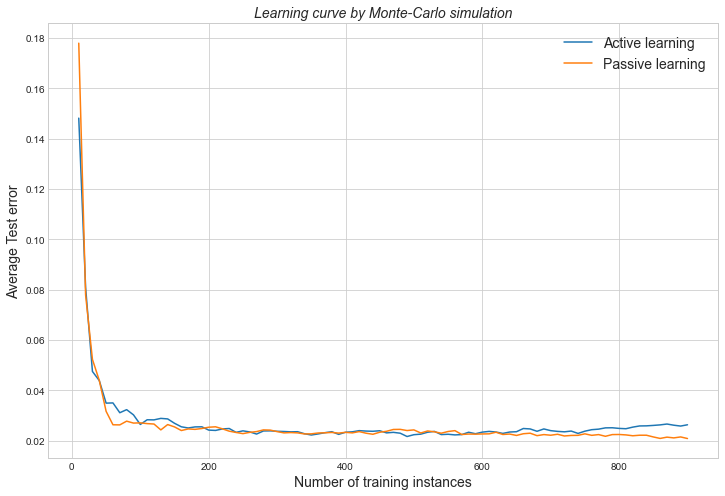

In [40]:
print("Average metrics of Passive Learning Monte-Carlo simulation:\n")
print(tabulate(metrics_summaries['Passive Learning: L1-penalized SVC with CV'], tableHeaders, tablefmt="grid"),"\n")
print("Average metrics of Active Learning Monte-Carlo simulation:\n")
print(tabulate(metrics_summaries['Active Learning: L1-penalized SVC with CV'], tableHeaders, tablefmt="grid"),"\n")

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(8)
ax = plt.axes()
x = np.arange(10,910,10)
ax.plot(x, al_curve, label='Active learning');
ax.plot(x, pl_curve, label='Passive learning');
plt.xlabel('Number of training instances', size = 14)
plt.ylabel('Average Test error', size = 14)
plt.title('Learning curve by Monte-Carlo simulation', style = 'oblique', size = 14)
plt.legend(prop={'size': 14})
plt.show()

On observing the above plot, we see that initially when there are less samples for training, passive learning has a high average test error than active learning because passive learning adds the sample data points randomly in each iteration wheareas active learning selects samples based on their proximity to the hyperplane of the SVM. Then, as the training samples start increasing, we see that the average test error starts decreasing and then fluctuates between a slight increase or  constant pattern for both the learning models. This depicts the bias-variance tradeoff i.e. initially when there are very few training samples, model has a high bias and low variance hence contributing to a high average error on test data. And, as training samples increase, the variance of the model increases and the model starts becoming flexible with decreasing bias as a result, causing decrease in the average error on test data.<br>
If our model is too simple and has very few training samples then it has high bias and low variance. On the other hand, if our model has large number of training samples then it’s going to have high variance and low bias. So we need to find the right/good balance without overfitting and underfitting the data.<br>
In this case, we can see that passive learning model reaches the lowest average test error because it has slightly less test error as compared to active learning model when the model was trained on all 900 samples.

In [39]:
print("Average Metrics Summary:\n")
for key in metrics_summaries.keys():
    print(key,":")
    print(tabulate(metrics_summaries[key], tableHeaders, tablefmt="grid"),"\n")

Average Metrics Summary:

Supervised Learning: L1-penalized SVC with CV :
+--------+-----------+------------+-------------+----------+------------+----------+
| data   |     error |   accuracy |   precision |   recall |   f1-score |      AUC |
+========+===========+============+=============+==========+============+==========+
| Train  | 0.0190162 |   0.980984 |    0.98328  | 0.976184 |   0.979476 | 0.97618  |
+--------+-----------+------------+-------------+----------+------------+----------+
| Test   | 0.0704348 |   0.929565 |    0.930294 | 0.938286 |   0.927363 | 0.938287 |
+--------+-----------+------------+-------------+----------+------------+----------+ 

Semi-supervised Learning: L1-penalized SVC with CV :
+--------+------------+------------+-------------+----------+------------+---------+
| data   |      error |   accuracy |   precision |   recall |   f1-score |     AUC |
+========+============+============+=============+==========+============+=========+
| Train  | 0.00807636

# References

https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29<br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html#scipy.cluster.vq.vq<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html<br>
https://www.absolutdata.com/learn-analytics-whitepapers-webinars/spectral-clustering/<br>
https://archive.ics.uci.edu/ml/datasets/banknote+authentication